## Demonstration of Audio Denoising

This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Data-Driven Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).

The denoising of audio samples is demonstrated using a deep neural regression network consisting of convolutional layers. The noisy input signal is split into overlapping segments and the magnitude of the short-time Fourier transform (STFT) of the current and 7 past segments is used as feature. The output for the supervised training is the magnitude of the STFT of the current segment of the noise-free signal.

This example was inspired by the paper of ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

from scipy.signal import decimate
from librosa import stft, istft

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Normalization, Conv2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

2022-01-20 15:45:41.238072: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 15:45:41.238131: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
training_path = '../data/froschkoenig_female_speaker.wav'  # clean audio file used for training
noise_path = '../data/babble_noise.wav'  # additive noise for impairment of clean audio
testing_path = '../data/single_words_female_speaker.wav'  # clean audio used for testing the network

### Generate Examples

The features/outputs used for training the regression network are computed by impairing a clean speech recording by babble noise.

In [3]:
def generate_features(y, n, n_fft=256, hop_length=64, nseg=8):

    # normalize inputs
    y = y/np.max(np.abs(y[:]))
    n = n/np.max(np.abs(n[:]))

    # add background noise to signal
    x = y + .7 * n[:len(y)]
    x = x/np.max(np.abs(x[:]))

    # STFTs of clean and noisy signal
    Y = stft(y, n_fft=n_fft, hop_length=hop_length).T
    Y = np.abs(Y)
    X = stft(x, n_fft=n_fft, hop_length=hop_length).T
    phiX = np.angle(X[nseg-1:, :])
    X = np.abs(X)

    # stack segments as features
    Y = Y[nseg-1:, :]
    X = [X[n:n+nseg, :] for n in range(len(Y))]
    X = np.array(X)

    return X, x, Y, phiX

In [4]:
y, fs = sf.read(training_path)
y = decimate(y, 2)
fs = fs//2

n, _ = sf.read(noise_path)
n = n[:, 0]
n = decimate(n, 2)
n = np.hstack((n, n, n))

X, x, Y, phiX = generate_features(y, n)

print(f'dimensions of features {X.shape}')
print(f'dimensions of outputs {Y.shape}')

dimensions of features (49956, 8, 129)
dimensions of outputs (49956, 129)


Let's listen to the noisy audio used for the training

In [5]:
sf.write('training_example.wav', x, fs)

<audio src="training_example.wav" controls>

### Define and Train the Model

The model is defined as a concatenation of an input layer, a normalization layer, a series of convolutional layers and an output layer. For the model, the output shapes of the individual layers, as well as the number of parameters that have to be determined in the training phase are summarized.

In [6]:
normalizer = Normalization()


def cnn_model(input_shape=(8, 129, 1)):

    inputs = Input(shape=input_shape)
    
    x = normalizer(inputs)
    
    x = Conv2D(64, (3,3), padding=('valid'))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3,3), padding=('valid'))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3,3), padding=('valid'))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(32, (2,5), padding=('valid'))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(32, (1,5), padding=('valid'), strides=(1,4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (1,5), padding=('valid'))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (1,5), padding=('valid'), strides=(1,4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, (1,5), padding=('valid'))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Flatten()(x)
    x = Dense(129)(x)

    return Model(inputs, x)


model = cnn_model()
model.summary()

2022-01-20 15:45:55.096191: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 15:45:55.096855: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-20 15:45:55.097489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-20 15:45:55.098131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-01-20 15:45:55.098770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 129, 1)]       0         
                                                                 
 normalization (Normalizatio  (None, 8, 129, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 6, 127, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 6, 127, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 6, 127, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 125, 64)        36928 

Now the model is 'compiled' using the mean-squared error (MSE) as loss function together with the Adam optimizer. The examples are split into two subsets of training and validation examples. In order to avoid overfitting, Early Stopping is used to stop the training after convergence has been reached.

In [7]:
model.compile(loss="mse", optimizer="adam")

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

normalizer.adapt(X_train)

callback = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X, Y, validation_data=(X_test, Y_test), callbacks=[callback], epochs=100, batch_size=128)

Epoch 1/100
391/391 [==============================] - 43s 107ms/step - loss: 0.2861 - val_loss: 0.2342
Epoch 2/100
391/391 [==============================] - 40s 103ms/step - loss: 0.1325 - val_loss: 0.1418
Epoch 3/100
391/391 [==============================] - 40s 102ms/step - loss: 0.1177 - val_loss: 0.1931
Epoch 4/100
391/391 [==============================] - 40s 103ms/step - loss: 0.1089 - val_loss: 0.1268
Epoch 5/100
391/391 [==============================] - 40s 101ms/step - loss: 0.0996 - val_loss: 0.0909
Epoch 6/100
391/391 [==============================] - 39s 101ms/step - loss: 0.0939 - val_loss: 0.1346
Epoch 7/100
391/391 [==============================] - 39s 100ms/step - loss: 0.0905 - val_loss: 0.0904
Epoch 8/100
391/391 [==============================] - 39s 100ms/step - loss: 0.0859 - val_loss: 0.0893
Epoch 9/100
391/391 [==============================] - 39s 101ms/step - loss: 0.0812 - val_loss: 0.0962
Epoch 10/100
391/391 [==============================] - 39s 100m

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 39s 101ms/step - loss: 0.0448 - val_loss: 0.0475
Epoch 40/100
391/391 [==============================] - 39s 100ms/step - loss: 0.0439 - val_loss: 0.0422
Epoch 41/100
391/391 [==============================] - 39s 100ms/step - loss: 0.0446 - val_loss: 0.0453
Epoch 42/100
391/391 [==============================] - 39s 101ms/step - loss: 0.0430 - val_loss: 0.0472
Epoch 43/100
391/391 [==============================] - 39s 100ms/step - loss: 0.0430 - val_loss: 0.0414
Epoch 44/100
391/391 [==============================] - 39s 100ms/step - loss: 0.0421 - val_loss: 0.0393
Epoch 45/100
391/391 [==============================] - 39s 101ms/step - loss: 0.0421 - val_loss: 0.0413
Epoch 46/100
391/391 [==============================] - 39s 101ms/step - loss: 0.0416 - val_loss: 0.0500
Epoch 47/100
391/391 [==============================] - 40s 101ms/step - loss: 0.0418 - val_loss: 0.0456
Epoch 48/100
391/391 [==============================] - 39s 99ms/ste

### Evaluation of the Model

First we take a look at the evolution of the mean-squared error over the epochs.

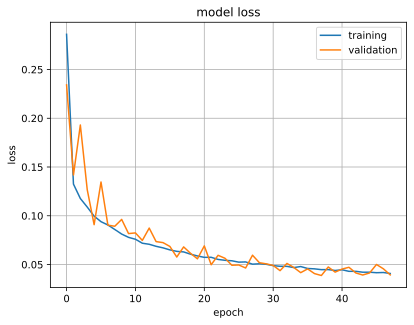

In [8]:
def plot_history(history, key):
    plt.figure()
    plt.plot(history.history[key], label='training')
    plt.plot(history.history[f'val_{key}'], label='validation')
    plt.title(f'model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()


plot_history(history, 'loss')

In order to test the model, an unseen audio example is denoised by the trained model. In order to denoise the signal with the trained network, the phase is extracted from the STFT before taking its magnitude. The input features are then fed through the network in order to compute the denoised STFT of the actual segment. The extracted phase is then used to recover the output segment using an inverse STFT.

In [9]:
y_test, _ = sf.read(testing_path)
y_test = decimate(y_test, 2)

X_test, x_test, Y_test, phiX_test = generate_features(y_test, n)

Yd = model.predict(X_test)
yd = istft(Yd.T * np.exp(1j*phiX_test).T)
yd = yd / np.max(np.abs(yd[:]))

sf.write('clean_example.wav', y_test, fs)
sf.write('noisy_example.wav', x_test, fs)
sf.write('denoised_example.wav', yd, fs)

Lets listen to the noisy and denoised example to explore the performance of the model

**Clean example**

<audio src="clean_example.wav" controls>

**Example impaired by babble noise**

<audio src="noisy_example.wav" controls>

**Denoised example**

<audio src="denoised_example.wav" controls>

**Copyright**

This notebook is provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources).
The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/)
, the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: Sascha Spors, Data driven audio signal processing - Lecture supplementals.